In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 49 kB/s 
     |████████████████████████████████| 199 kB 54.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=14ca5662a281bef658f0b57e7103ad27357509294cf85a138b3d5b43d99e5cd7
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

In [ ]:
spark = SparkSession.builder.appName('PCA').getOrCreate()
iris = load_iris()
X = iris['data']
y = iris['target']

In [ ]:
data = pd.DataFrame(X, columns = iris.feature_names)
dataset = spark.createDataFrame(data, iris.feature_names)
dataset.show(6)

+-----------------+----------------+-----------------+----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|
+-----------------+----------------+-----------------+----------------+
|              5.1|             3.5|              1.4|             0.2|
|              4.9|             3.0|              1.4|             0.2|
|              4.7|             3.2|              1.3|             0.2|
|              4.6|             3.1|              1.5|             0.2|
|              5.0|             3.6|              1.4|             0.2|
|              5.4|             3.9|              1.7|             0.4|
+-----------------+----------------+-----------------+----------------+
only showing top 6 rows



In [ ]:
assembler = VectorAssembler(
    inputCols = iris.feature_names, outputCol = 'features')

df = assembler.transform(dataset).select('features')
df.show(6)


+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
+-----------------+
only showing top 6 rows



In [ ]:
scaler = StandardScaler(
    inputCol = 'features',
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df)

In [ ]:
df_scaled = scaler.transform(df)
df_scaled.show(6)

+-----------------+--------------------+
|         features|      scaledFeatures|
+-----------------+--------------------+
|[5.1,3.5,1.4,0.2]|[-0.8976738791967...|
|[4.9,3.0,1.4,0.2]|[-1.1392004834649...|
|[4.7,3.2,1.3,0.2]|[-1.3807270877331...|
|[4.6,3.1,1.5,0.2]|[-1.5014903898672...|
|[5.0,3.6,1.4,0.2]|[-1.0184371813308...|
|[5.4,3.9,1.7,0.4]|[-0.5353839727944...|
+-----------------+--------------------+
only showing top 6 rows



In [ ]:
n_components = 2
pca = PCA(
    k = n_components,
    inputCol = 'scaledFeatures',
    outputCol = 'pcaFeatures'
).fit(df_scaled)

In [ ]:
df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance Ratio [0.72962445 0.22850762]
+-----------------+--------------------+--------------------+
|         features|      scaledFeatures|         pcaFeatures|
+-----------------+--------------------+--------------------+
|[5.1,3.5,1.4,0.2]|[-0.8976738791967...|[2.25714117564811...|
|[4.9,3.0,1.4,0.2]|[-1.1392004834649...|[2.07401301519962...|
|[4.7,3.2,1.3,0.2]|[-1.3807270877331...|[2.35633511180617...|
|[4.6,3.1,1.5,0.2]|[-1.5014903898672...|[2.29170678586969...|
|[5.0,3.6,1.4,0.2]|[-1.0184371813308...|[2.38186270441693...|
|[5.4,3.9,1.7,0.4]|[-0.5353839727944...|[2.06870060846769...|
+-----------------+--------------------+--------------------+
only showing top 6 rows



In [ ]:
X_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


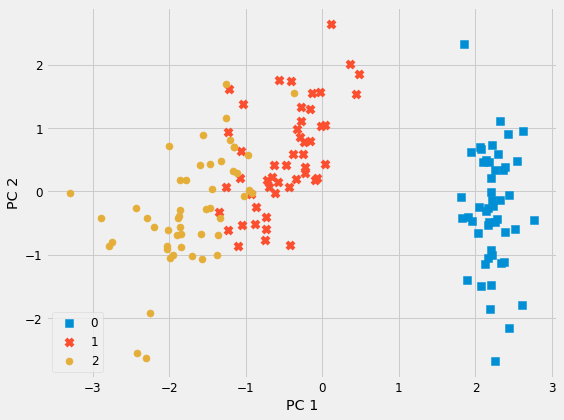

In [ ]:
def plot_iris_pca(X_pca, y):
    """a scatter plot of the 2-dimensional iris data"""
    markers = 's', 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()
plot_iris_pca(X_pca, y)

In [ ]:
spark.stop()